# Import required libraries

In [1]:
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("./Models/" + title + ".png")
    return ax


np.set_printoptions(precision=2)

In [3]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Dataset loading and normalization

In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data normalization
x_train = x_train.astype('float32')
x_test =  x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# Label encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# MLP

## MLP Creation

In [ ]:
MLP = Sequential()
MLP.add(Flatten(input_shape=[32, 32,3]))
MLP.add(Dense(1541, activation="relu"))
MLP.add(Dense(770, activation="relu"))
MLP.add(Dense(10, activation="softmax"))
MLP.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
# Show the summary of model architecture
MLP.summary()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## MLP training

In [ ]:
# Prepare callback function to monitor the performance during training
log_dir = "logs\\MLP\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Train the MLP
history = MLP.fit(x=x_train, y=y_train, epochs=2000, batch_size=16,
                               validation_data=(x_test, y_test), verbose=0,callbacks=[tensorboard_callback])

## Save MLP

In [ ]:
# Save the model
MLP.save('./Models/MLP.h5')

In [ ]:
y_pred=MLP.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

Normalized confusion matrix


<AxesSubplot:title={'center':'MLP Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

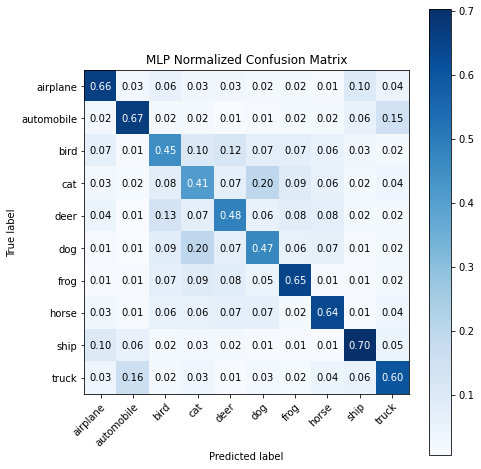

In [10]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='MLP Normalized Confusion Matrix')

In [8]:
accuracy_score(y_true,y_pred)

0.5729

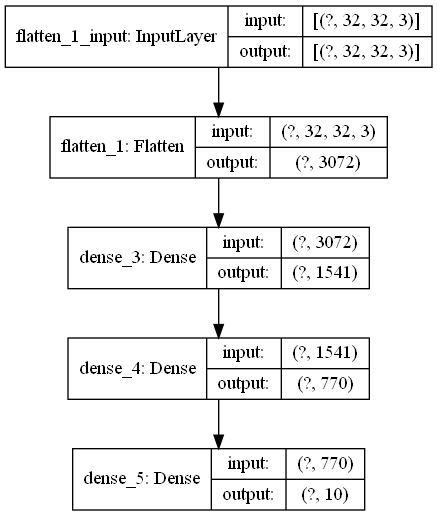

In [4]:
plot_model(MLP, to_file='./Models/MLP.png',show_shapes=True)

# Transfer Learning

## Data preparation

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#One-hot encode the labels.
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

## Prepare ImageDataGenerator

In [ ]:
#Data Augmentation
train_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip= True,
                                    zoom_range=.1)

### Fit ImageDataGenerator

In [ ]:
#Fit the image data generator to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate

## VGG19

### Build the model

#### Load pretrained VGG19

In [ ]:
#VGG19 with imagenet weights
base_vgg19 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])


In [ ]:
vgg19= Sequential()
vgg19.add(base_vgg19)
vgg19.add(Flatten())

In [ ]:
vgg19.summary()

In [ ]:
vgg19.add(Dense(1024,activation=('relu'),input_dim=512))
vgg19.add(Dense(512,activation=('relu')))
vgg19.add(Dense(256,activation=('relu')))
vgg19.add(Dense(128,activation=('relu')))
vgg19.add(Dense(10,activation=('softmax')))


In [2]:
vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [ ]:
batch_size= 100
epochs=50

In [ ]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
vgg19.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
vgg19.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)


In [11]:
y_pred=vgg19.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
vgg19.save("./Models/VGG19.h5")

Normalized confusion matrix


<AxesSubplot:title={'center':'VGG19 Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

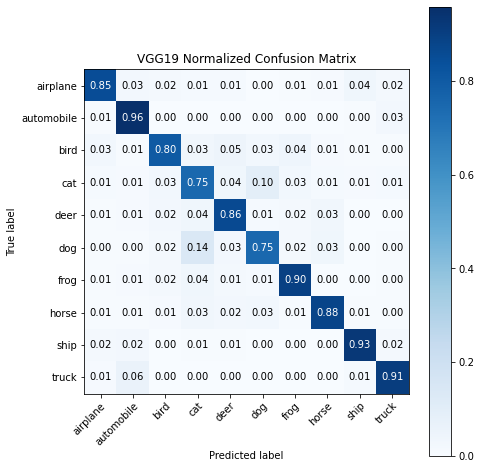

In [12]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='VGG19 Normalized Confusion Matrix')

In [13]:
accuracy_score(y_true,y_pred)

0.8593

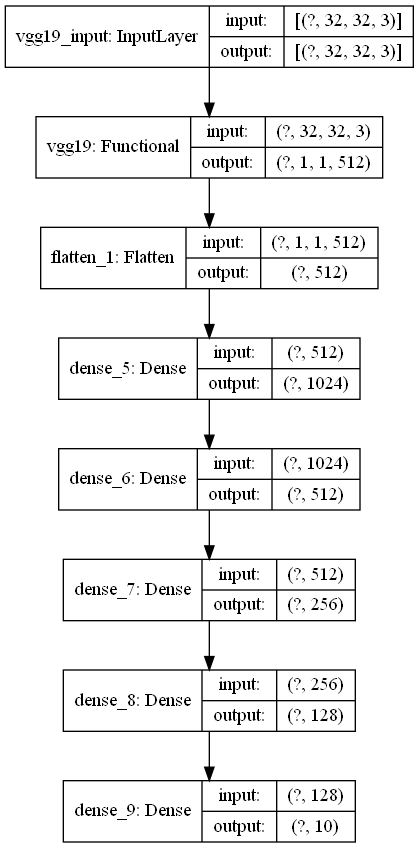

In [7]:
plot_model(vgg19, to_file='./Models/VGG19.png',show_shapes=True)

## ResNet50

### Build the model

#### Load pretrained ResNet50

In [ ]:
#Resnet50 with imagenet weights
base_resnet50 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [ ]:
resnet50=Sequential()
resnet50.add(base_resnet50)
resnet50.add(Flatten())

resnet50.add(Dense(4000,activation=('relu'),input_dim=512))
resnet50.add(Dense(2000,activation=('relu')))
resnet50.add(Dropout(.4))
resnet50.add(Dense(1000,activation=('relu')))
resnet50.add(Dropout(.3))
resnet50.add(Dense(500,activation=('relu')))
resnet50.add(Dropout(.2))
resnet50.add(Dense(10,activation=('softmax')))

In [ ]:
resnet50.summary()

In [ ]:
resnet50.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
resnet50.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                     epochs=100,steps_per_epoch=x_train.shape[0]//batch_size,
                     validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

In [14]:
y_pred_resnet=resnet50.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Normalized confusion matrix


<AxesSubplot:title={'center':'ResNet50 Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

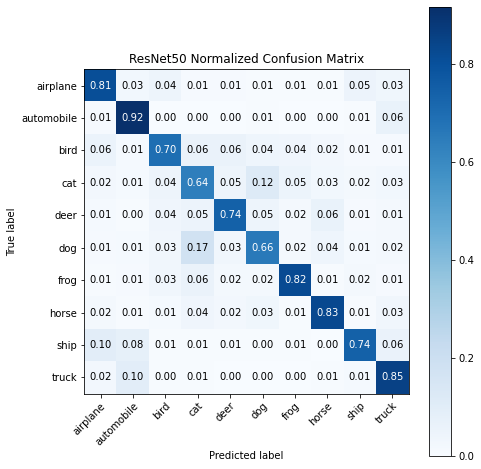

In [15]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names, normalize=True,
                      title='ResNet50 Normalized Confusion Matrix')

In [16]:
accuracy_score(y_true,y_pred)

0.8593

In [ ]:
resnet50.save("./Models/ResNet50.h5")

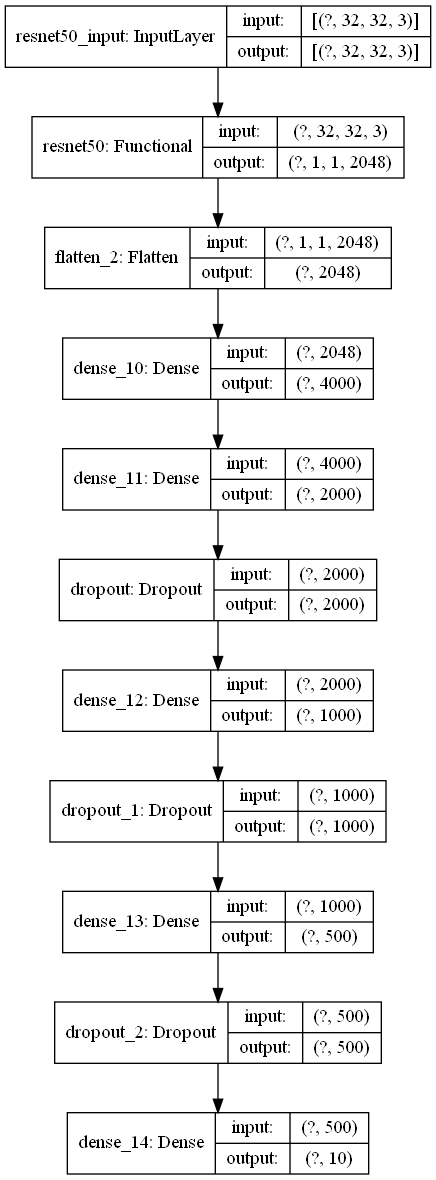

In [6]:
plot_model(resnet50, to_file='./Models/ResNet50.png',show_shapes=True)